In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import sys
sys.path.append('./utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
import h5py
import delay_embedding as embed
import operator_calculations as op_calc
import clustering_methods as cl

In [2]:
n_pca_modes=20
f= h5py.File('../data/Zebrafish/zebrafish_data.h5','r')
print(f.keys())
cov = np.array(f['cov'])
data_means = np.array([f['data_means']])
eigvecs = np.array(f['eigvecs'])
max_shuffles = np.array(f['max_shuffs'])
pca_fish = ma.masked_invalid(np.array(f['pca_fish']))[:,:,:n_pca_modes]
var_exp = np.array(f['var_exp'])
f.close()
pca_fish[pca_fish==0]=ma.masked

<KeysViewHDF5 ['cov', 'data_means', 'eigvecs', 'max_shuffs', 'pca_fish', 'var_exp']>


# embedding

In [3]:
cluster_range = np.logspace(1,3.5,11)
K_range = np.arange(1,9)

In [4]:
n_fish = len(pca_fish)
idx=0
Ipreds_K_N = np.zeros((n_fish,len(K_range),len(cluster_range)))
hs_K_N = np.zeros((n_fish,len(K_range),len(cluster_range)))
for k,K in enumerate(K_range):
    for kN,N in enumerate(cluster_range):
        f = h5py.File('../data/Zebrafish/Ipreds/Ipreds_{}.h5'.format(idx),'r')
        Ipreds = np.array(f['Ipreds'])
        hs = np.array(f['hs'])
        f.close()
        Ipreds_K_N[:,k,kN] = Ipreds
        hs_K_N[:,k,kN] = hs
        idx+=1

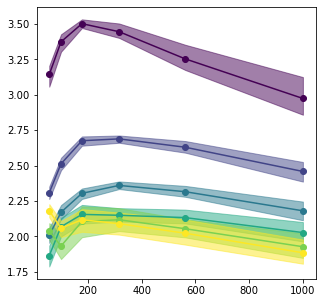

In [5]:
plt.figure(figsize=(5,5))
colors_K = plt.cm.viridis(np.linspace(0,1,len(K_range[:6])))
for k,K in enumerate(K_range[:6]):
    mean,cil,ciu = stats.bootstrap(hs_K_N[:,k,3:-2],n_times=100)
    plt.plot(cluster_range[3:-2],mean,c=colors_K[k],marker='o')
    plt.fill_between(cluster_range[3:-2],cil,ciu,alpha=.5,color=colors_K[k])
# plt.xscale('log')
plt.show()

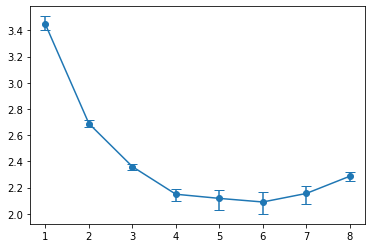

In [6]:
kN=6
mean,cil,ciu = stats.bootstrap(hs_K_N[:,:,kN],n_times=100)
plt.errorbar(K_range,mean,yerr=[mean-cil,ciu-mean],marker='o',capsize=5)
plt.show()

# optimal h

In [7]:
data_dt=1
delay=3

ctraj_path = '../data/Zebrafish/ctrajs_562_clusters_delay_{}/'.format(delay)
f = h5py.File(ctraj_path+'/c_traj_fish.h5','r')
mD = f['MetaData']
n_clusters = np.array(mD['n_clusters'],dtype=int)[0]
delay = np.array(mD['delay'],dtype=int)[0]
ctraj_fish = ma.array(f['ctraj_fish'])
ctraj_fish_mask = ma.array(f['ctraj_fish_mask'])
f.close()
ctraj_fish[ctraj_fish_mask==1]=ma.masked

In [8]:
n_sims=100
delta_hs = []
for k in range(n_sims):
    f = h5py.File('../data/Zebrafish/optimize_h_delay_3/delta_h_{}.h5'.format(k),'r')        
    delta_h = np.array(f['delta_h'])
    h_range = np.array(f['h_range'])
    dx = np.array(f['dx'])[0]
    stride = np.array(f['stride'])[0]
    f.close()
    delta_hs.append(delta_h)

In [9]:
mean_D1,cil_D1,ciu_D1 = stats.bootstrap(np.diff(ma.masked_invalid(np.array(delta_hs)[:,:,0]),axis=1),n_times=1000)

In [10]:
mean_D2,cil_D2,ciu_D2 = stats.bootstrap(np.diff(ma.masked_invalid(np.array(delta_hs)[:,:,1]),axis=1),n_times=1000)

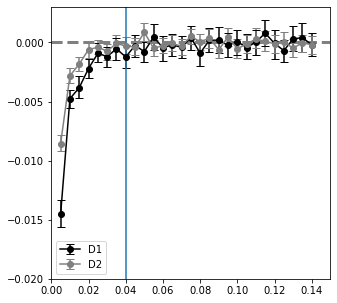

In [11]:
plt.figure(figsize=(5,5))
plt.errorbar(h_range[:-1],mean_D1,yerr = [mean_D1-cil_D1,ciu_D1-mean_D1],capsize=4,marker='o',c='k',label='D1')
plt.errorbar(h_range[:-1],mean_D2,yerr = [mean_D2-cil_D2,ciu_D2-mean_D2],capsize=4,marker='o',c='gray',label='D2')
plt.legend()
plt.axhline(0,ls='--',c='gray',lw=3)
plt.axvline(0.04)
plt.xlim(0,0.15)
plt.ylim(-.02,0.003)
# plt.savefig('delta_hs.pdf')
plt.show()

#  Illustrate phi2 reconstruction

In [12]:
def reconstruct_bout(X,eigvecs,n_pca_modes=20,maxT=175,ntail_angles=8):
    return X.dot(eigvecs[:,:n_pca_modes].T).reshape(maxT,ntail_angles)

In [13]:
kf=7
unique_vals = np.unique(ctraj_fish[kf].compressed())
colors_ctraj = plt.cm.coolwarm(np.linspace(0,1,len(unique_vals)))

In [14]:
kb0,kbf = 10546, 10588

In [15]:
f= h5py.File('../data/Zebrafish/zebrafish_pos_data.h5','r')
Xhead = ma.array(f['X_head'])
Xhead[Xhead==0] = ma.masked
times_bouts = ma.array(f['times_bouts'])
f.close()

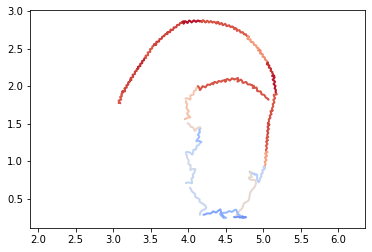

In [16]:
#170pix/cm
for kb in range(kb0,kbf):
    if kb<=ma.count(ctraj_fish[kf]):
        val = ctraj_fish[kf][kb]
        idx = np.argmin(np.abs(val-unique_vals))
        plt.plot(Xhead[kf][kb][:,0]/170,Xhead[kf][kb][:,1]/170,c=colors_ctraj[idx],lw=2)
plt.axis('equal')
# plt.savefig('bout_seq_spatial_traj_color_code_ctraj.pdf')
plt.show()

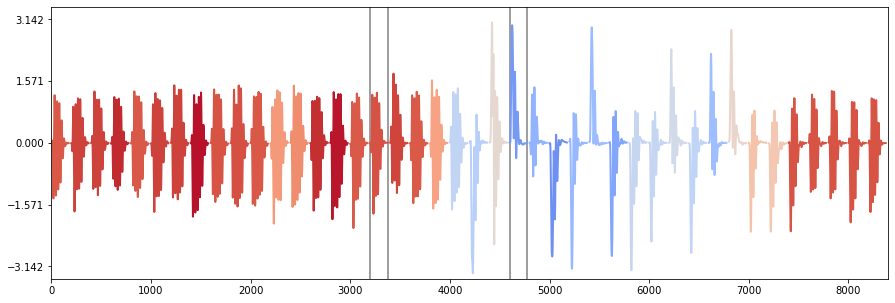

In [17]:
plt.figure(figsize=(15,5))
colors_ctraj = plt.cm.coolwarm(np.linspace(0,1,len(unique_vals)))
t0=0
for kb in range(kb0,kbf):
    val = ctraj_fish[kf][kb]
    if kb==kb0+16 or kb==kb0+23:
        plt.axvline(t0,c='gray')
        plt.axvline(t0+175,c='gray')
    if ma.count(val)>0:
        idx = np.argmin(np.abs(val-unique_vals))
        theta = reconstruct_bout(pca_fish[kf][kb],eigvecs)
        plt.plot(np.arange(t0,t0+175),theta[:,-1],c=colors_ctraj[idx],lw=2)
        t0+=200
plt.ylim(-1.1*np.pi,1.1*np.pi)
plt.yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
plt.xlim(0,8400)
# plt.savefig('bout_seq_last_angle_color_code_ctraj.pdf')
plt.show()

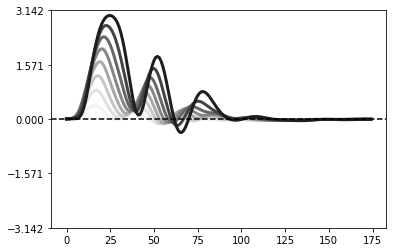

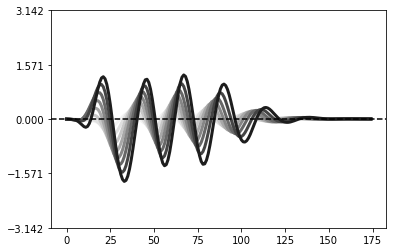

In [18]:
maxT = 175
ntail_angles=8
colors_angles = plt.cm.Greys(np.linspace(0.1,.9,ntail_angles))
theta = reconstruct_bout(pca_fish[kf][kb0+23],eigvecs)
for ka in range(ntail_angles):
    plt.plot(theta[:,ka],c=colors_angles[ka],lw=3)
plt.yticks(np.arange(-np.pi,np.pi+.1,np.pi/2))
plt.ylim(-np.pi,np.pi)
plt.axhline(0,ls='--',c='k')
# plt.savefig('example_bout_turn1.pdf')
plt.show()


maxT = 175
ntail_angles=8
colors_angles = plt.cm.Greys(np.linspace(0.1,.9,ntail_angles))
theta = reconstruct_bout(pca_fish[kf][kb0+16],eigvecs)
for ka in range(ntail_angles):
    plt.plot(theta[:,ka],c=colors_angles[ka],lw=3)
plt.axhline(0,ls='--',c='k')
plt.yticks(np.arange(-np.pi,np.pi+.1,np.pi/2))
plt.ylim(-np.pi,np.pi)

# plt.savefig('example_bout_fwd1.pdf')

plt.show()

# probability of states over time

In [19]:
wsize = 60*5*1000
max_tbouts = 60*60*1000
wrange = np.arange(0,max_tbouts,wsize)
pcruising_fish = ma.zeros((len(times_bouts),wrange.shape[0]))
pwandering_fish = ma.zeros((len(times_bouts),wrange.shape[0]))
for kf in range(len(times_bouts)):
    for kt,t0 in enumerate(wrange):
        tf = t0+wsize
        sel = np.logical_and(times_bouts[kf][:,0]>t0,times_bouts[kf][:,0]<tf)
        if sel.sum()>0:
            sel = np.logical_and(times_bouts[kf][:,0]>t0,times_bouts[kf][:,0]<tf)
            pcruising_fish[kf,kt] = (ctraj_fish[kf][sel]>0).sum()/ma.count(ctraj_fish[kf][sel])
            pwandering_fish[kf,kt] = (ctraj_fish[kf][sel]<0).sum()/ma.count(ctraj_fish[kf][sel])
    print(kf)

0
1
2
3
4
5
6
7
8
9
10


In [20]:
pcruising_fish[pcruising_fish==0] = ma.masked
pwandering_fish[pwandering_fish==0] = ma.masked

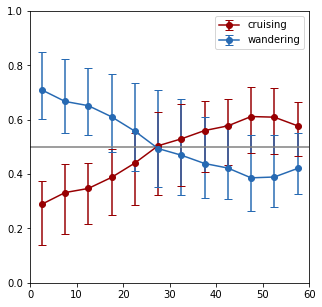

In [21]:
plt.figure(figsize=(5,5))
plt.axhline(0.5,c='gray')
mean,cil,ciu = stats.bootstrap(pcruising_fish,n_times=100)
plt.errorbar(wrange+wsize/2,mean,[mean-cil,ciu-mean],capsize=4,fmt='o-',c='#980002',label='cruising')
mean,cil,ciu = stats.bootstrap(pwandering_fish,n_times=100)
plt.errorbar(wrange+wsize/2,mean,[mean-cil,ciu-mean],capsize=4,fmt='o-',c='#276ab3',label='wandering')
# plt.fill_between(wrange,cil,ciu,alpha=.5)
plt.xticks(np.hstack([wrange[::2],wrange[-1]+wsize]),np.arange(0,61,10))
plt.xlim(0,wrange[-1]+wsize)
plt.ylim(0,1)
plt.legend()
# plt.savefig('crusing_rate_time_errbar_0_1.pdf')
plt.show()

# First-passage times

In [22]:
f=h5py.File('../data/Zebrafish/fpts_errbars.h5','r')
x_sim = np.array(f['x_sim'])
y_err_sim = np.array(f['y_err_sim'])
x_sim_tv = np.array(f['x_sim_tv'])
y_err_sim_tv = np.array(f['y_err_sim_tv'])
x_data= np.array(f['x_data'])
y_err_data = np.array(f['y_err_data'])
f.close()

In [23]:
colors_state_=plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]

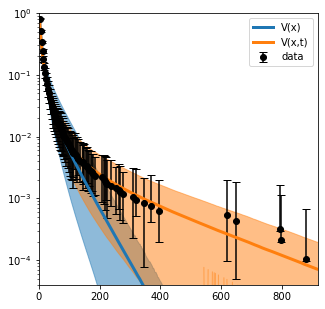

In [24]:
plt.figure(figsize=(5,5))
plt.errorbar(x_data[:-1],y_err_data[:-1,0],yerr = [y_err_data[:-1,0]-y_err_data[:-1,1],y_err_data[:-1,2]-y_err_data[:-1,0]],c='k',marker='o',fmt='o',capsize=4,label='data')
plt.plot(x_sim[:-1],y_err_sim[:-1,0],c=colors_state_[0],lw=3,label='V(x)')
plt.fill_between(x_sim[:-1],y_err_sim[:-1,1],y_err_sim[:-1,2],alpha=.5,color=colors_state_[0])
plt.plot(x_sim_tv[:-1],y_err_sim_tv[:-1,0],c=colors_state_[1],lw=3,label='V(x,t)')
plt.fill_between(x_sim_tv[:-1],y_err_sim_tv[:-1,1],y_err_sim_tv[:-1,2],alpha=.5,color=colors_state_[1])
plt.legend()
plt.xlim(0,920)
plt.ylim(4e-5,1)
# trange = np.linspace(0,400)
# plt.plot(trange,5e-2*np.exp(-trange/50),c='k')
# plt.xscale('log')
plt.yscale('log')
# plt.savefig('fpt_V(x,t)_fish.pdf')
plt.show()

# acfs

In [25]:
C_fish = []
C_sims_fish = []
C_sims_tv_fish=[]
for kf in range(len(ctraj_fish)):
    f = h5py.File('../data/Zebrafish/sims_acfs/acfs_fish_{}.h5'.format(kf),'r')
    C_data = np.array(f['C_data'])
    C_sims = np.array(f['C_sims'])
    C_sims_tv = np.array(f['C_sims_tv'])
    lags = np.array(f['lags'],dtype=int)
    f.close()
    C_fish.append(C_data)
    C_sims_fish.append(C_sims)
    C_sims_tv_fish.append(C_sims_tv)

In [26]:
C_sims_fish = np.array(C_sims_fish)
C_sims_tv_fish = np.array(C_sims_tv_fish)
C_fish = np.array(C_fish)

In [27]:
def bootstrap(C_sims_fish,n_boot=100):
    mean = C_sims_fish.mean(axis=0).mean(axis=0)
    means = [C_sims_fish[np.random.randint(0,C_sims_fish.shape[0],C_sims_fish.shape[0]),np.random.randint(0,C_sims_fish.shape[0],C_sims_fish.shape[0]),:].mean(axis=0) for k in range(n_boot)]
    cil = np.percentile(means,2.5,axis=0)
    ciu = np.percentile(means,97.5,axis=0)
    return mean,cil,ciu

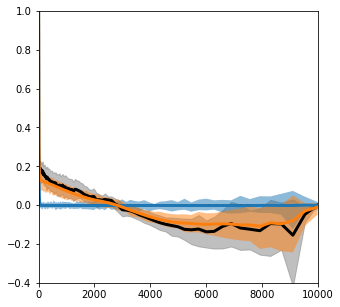

In [28]:
plt.figure(figsize=(5,5))
mean,cil,ciu = stats.bootstrap(C_fish,n_times=100)
plt.plot(lags,mean,c='k',lw=3)
plt.fill_between(lags,cil,ciu,alpha=.5,color='gray')
plt.axhline(0,ls='--',c='k')
mean,cil,ciu = bootstrap(C_sims_fish)
plt.plot(lags,mean,lw=3)
plt.fill_between(lags,cil,ciu,alpha=.5)
mean,cil,ciu = bootstrap(C_sims_tv_fish)
plt.plot(lags,mean,lw=3)
plt.fill_between(lags,cil,ciu,alpha=.5)
plt.xlim(0,10000)
plt.ylim(-0.4,1)
# plt.savefig('acf_fish.pdf')
plt.show()